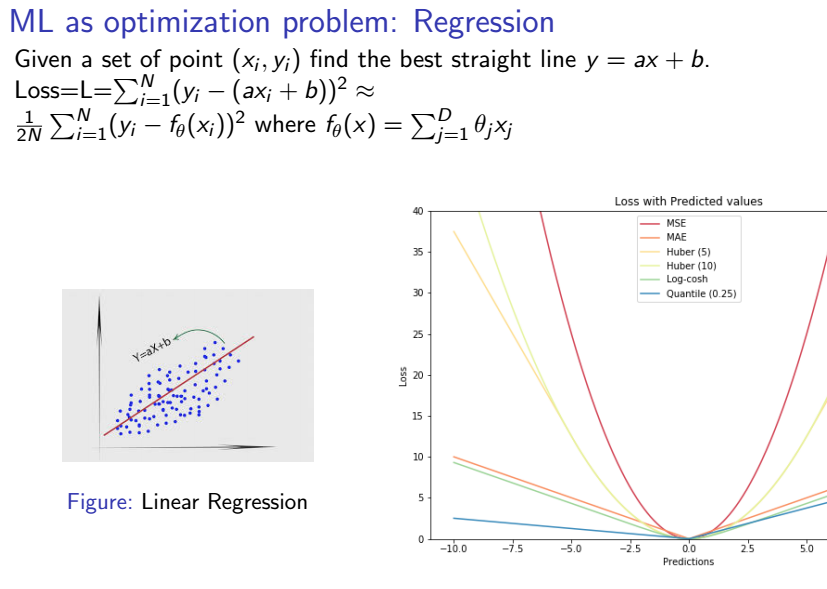

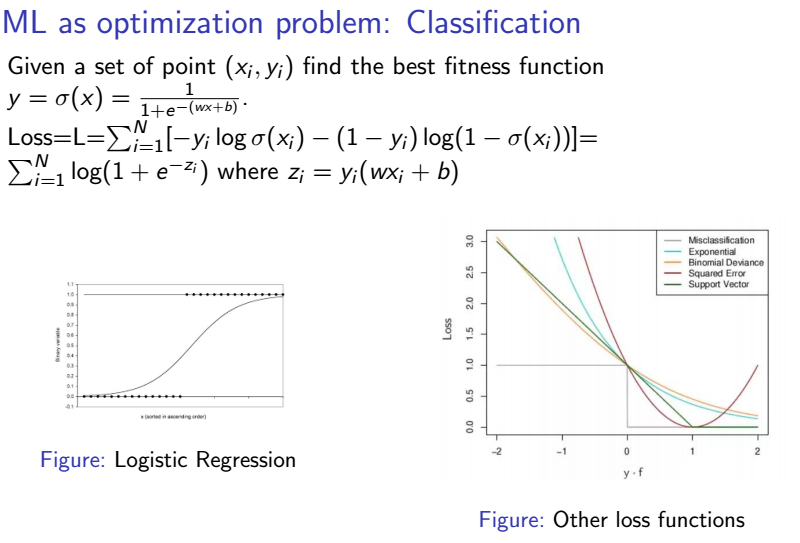

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#routines for book-keeping progress
#https://github.com/idc9/optimization_algos

def opt_history(model, beta_history, beta_solution):
    """
    Computes optimization history

    Parameters
    ----------
    model: optimization model
    beta_history: history of beta values

    Returns
    -------
    fun_history: function values
    grad_history: 2-norm of gradient
    beta_error: 2-norm error of beta from solution where solution is either
    provided or computed based on the min function value

    fun_history, grad_history, beta_error = opt_history(model, beta_history)
    """

    fun_history = [model.F(b) for b in beta_history]
    grad_history = [np.linalg.norm(model.grad_F(b)) for b in beta_history]



    beta_error = [np.linalg.norm(beta_solution - b) for b in beta_history]

    return fun_history, grad_history, beta_error

#routines for plotting progress
def plot_opt_path(beta_history, model, beta_solution, opt_algo=''):

    # model history
    fun_history, grad_history, beta_error = opt_history(model, beta_history, beta_solution)

    plt.figure(figsize=[15, 5])

    # absolutes
    plt.subplot(2, 3, 1)
    plt.plot(fun_history)
    plt.ylabel('function value')
    plt.xlabel('iteration')
    plt.title(opt_algo + ' for ' + model.name)

    plt.subplot(2, 3, 2)
    plt.plot(beta_error)
    plt.ylabel('||theta - theta*||')
    plt.xlabel('iteration')

    plt.subplot(2, 3, 3)
    plt.plot(grad_history)
    plt.ylabel('grad F')
    plt.xlabel('iteration')

#routines for generating data

def generate_LS_data(n, d, seed=None):
    """ samples random LS data"""

    if seed:
        np.random.seed(3312)

    X = np.random.normal(loc=0, scale=1, size=(n, d))
    y = np.random.normal(loc=0, scale=1, size=n)

    return X, y

def generate_logreg_data(n, d, seed=None):
    """samples random logistic regression data"""
    if seed:
        np.random.seed(3312)

    # X data with intercept
    X = np.random.normal(loc=0, scale=1, size=(n, d-1))
    X = np.array(np.bmat([X, np.ones((n, 1))]))  # add i ntercept to design matrix

    # true beta
    beta_platon = np.random.normal(loc=0, scale=1, size=d)

    # sample data
    prob = expit(np.dot(X, beta_platon))
    unif = np.random.sample(n)
    y = np.array([1 if unif[i] < prob[i] else -1 for i in range(n)])  # class labels

    return X, y, beta_platon



# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline


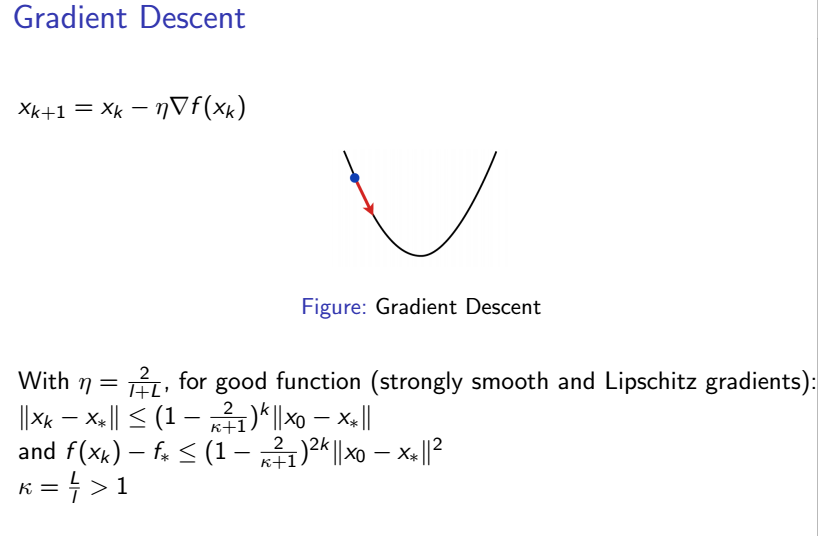

In [2]:
def gradient_descent(model, eta, max_iterations=1e4, epsilon=1e-5,
                     theta_start=None):
    """
    Gradient descent

    Parameters
    ----------
    model: optimization model object
    eta: learning rate
    max_iterations: maximum number of gradient iterations
    epsilon: tolerance for stopping condition
    theta_start: where to start (otherwise random)

    Output
    ------
    solution: final beta value
    theta_history: beta values from each iteration
    """

    # data from model
    grad_F = model.grad_F
    d = model.d
    # F = model.F

    # initialization
    if theta_start:
        theta_current = theta_start
    else:
        theta_current = np.random.normal(loc=0, scale=1, size=d)

    print("theta_current shape", theta_current.shape)
    
    # keep track of history
    theta_history = []

    for k in range(int(max_iterations)):

        theta_history.append(theta_current)

        # gradient update
        theta_next = theta_current - eta * grad_F(theta_current)

        # relative error stoping condition
        if np.linalg.norm(theta_next - theta_current) <= epsilon*np.linalg.norm(theta_current):
            #  if np.linalg.norm(theta_next) <= epsilon:
            break

        theta_current = theta_next

    print ('GD finished after ' + str(k) + ' iterations')

    return {'solution': theta_current,
            'theta_history': theta_history}


# Gradient descent for Linear Regression

#Generate  regression data

(100, 10)


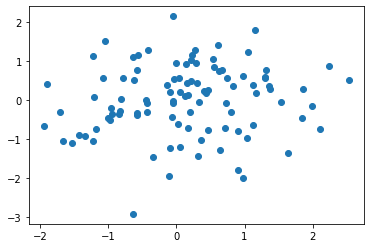

In [3]:

class LeastSquares(object):
    """
    Least squares

    min_theta ||X theta - y||_2^2

    X in R^(n x d)
    y in R^n
    theta in R^d
    """

    def __init__(self, X, y):
    
        self.name = "least squares"

        # data
        self.X = X
        self.y = y

        self.d = X.shape[1]
        self.n = X.shape[0]

        # lipshitz constant
        self.L_F = np.linalg.norm(X)**2
        self.mu_F = 0

    def F(self, theta):
        return .5*sum((np.dot(self.X, theta) - self.y)**2)

    def grad_F(self, theta):
        return np.dot(self.X.T, np.dot(self.X, theta) - self.y)

    def f(self, theta, i):
        return self.n*.5*(np.dot(self.X[i, :], theta) - self.y[i])**2

    def grad_f(self, theta, i):
        return self.n*(np.dot(self.X[i, :], theta) - self.y[i]) * self.X[i, :]

    def get_solution(self):
        """returns the analytic solution to the LS problem"""
        return np.dot(np.dot(np.linalg.inv(np.dot(self.X.T, self.X)),                      
                             self.X.T), self.y)

#generate instance 
n = 100
d = 10
X, y = generate_LS_data(n, d, seed=34234)
print(X.shape)
plt.plot(X[:,1],y,'o' )
# set up model
model = LeastSquares(X, y)

# analytic LS solution
theta_solution = model.get_solution()
                             # sample least squares data




eta: 0.0009529706213182774
theta_current shape (10,)
GD finished after 145 iterations
CPU times: user 82.4 ms, sys: 2.29 ms, total: 84.7 ms
Wall time: 79.1 ms


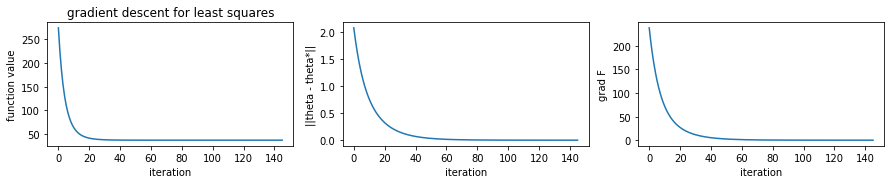

In [4]:
%%time
opt_algo = 'gradient descent'

eta = 1/model.L_F

print( 'eta: ' + str(eta))
GD_theta = gradient_descent(model, eta)['theta_history']
print
plot_opt_path(GD_theta, model, theta_solution, opt_algo)

# L2 regularization
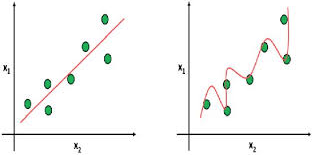

In [5]:
#Linear Regression with L2 regularization

eta: 0.0009527890253283867
theta_current shape (10,)
GD finished after 144 iterations


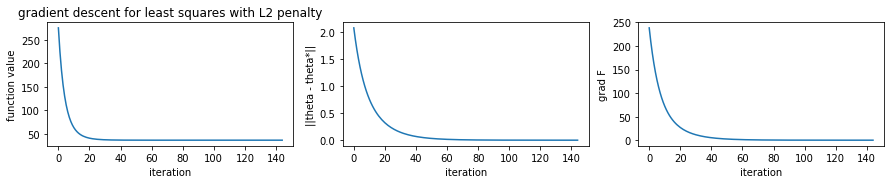

In [6]:
from sklearn import linear_model  # ridge regression
class LeastSquaresL2(object):
    """
    Least squares with L2 penalizaion

    min_theta ||X theta - y||_2^2 + alpha ||theta||_2^2

    X in R^(n x d)
    y in R^n
    theta in R^d
    alpha >0
    """

    def __init__(self, X, y, alpha):
        self.name = "least squares with L2 penalty"

        # data
        self.X = X
        self.y = y

        self.d = X.shape[1]
        self.n = X.shape[0]
        self.alpha = alpha

        # lipshitz constant
        self.L_F = np.linalg.norm(X)**2 + alpha
        self.mu_F = alpha

    def F(self, theta):
        return .5*sum((np.dot(self.X, theta) - self.y)**2) \
                    + self.alpha*np.linalg.norm(theta)**2

    def grad_F(self, theta):
        return np.dot(self.X.T, np.dot(self.X, theta) - self.y) \
                + self.alpha*theta

    def f(self, theta, i):
        return self.n*.5*(np.dot(self.X[i, :], theta) - self.y[i])**2 \
                + self.alpha*np.linalg.norm(theta)**2

    def grad_f(self, theta, i):
        return self.n*(np.dot(self.X[i, :], theta) - self.y[i]) * self.X[i, :] \
                + self.alpha*theta

    def get_solution(self):
        """solution based on sklearn's ridge regression"""
        # check solution using sklean
        sk_ridge_model = linear_model.Ridge(alpha=self.alpha,
                                            fit_intercept=False)
           #sk_ridge_model.fit(X=A, y=b)
        sk_ridge_model.fit(X=self.X, y=self.y)
        return sk_ridge_model.coef_

#generate instance 
n = 100
d = 10
X, y = generate_LS_data(n, d, seed=34234)
# set up model
alpha=0.2
model = LeastSquaresL2(X, y,alpha)

# analytic LS solution
theta_solution = model.get_solution()


opt_algo = 'gradient descent'

eta = 1/model.L_F

print( 'eta: ' + str(eta))
GD_theta = gradient_descent(model, eta)['theta_history']
print
plot_opt_path(GD_theta, model, theta_solution, opt_algo)

# Logistic Regression

eta: 0.011921325577235147
theta_current shape (10,)
GD finished after 815 iterations


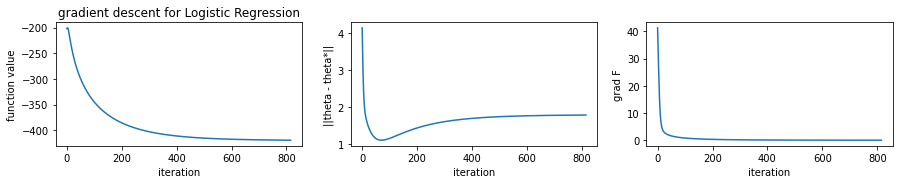

In [7]:
from scipy.special import expit


class LogisticRegression(object):
    """
    Logistic regression

    min_x sum_i log(1 + exp(b_i *a_i^Tx))

    A in R^(n x d) assumes the last column is all ones for the intercet
    b =+/-1 in R^n
    x in R^d
    """

    def __init__(self, X, y):

        # data
        self.X = X
        self.y = y
        self.name="Logistic Regression"

        self.d = X.shape[1]
        self.n = X.shape[0]

        # lipshitz constant
        self.L_F = .25 * np.linalg.norm(np.dot(X.T, X))

    def F(self, beta):
        return -1*logistic_loss(self.X, self.y, beta)

    def grad_F(self, beta):
        return -1*logistic_loss_grad(self.X, self.y, beta)

    def f(self, beta, i):
        return -1*self.n*logistic_loss(self.X[i, :], self.y[i], beta)

    def grad_f(self, beta, i):
        return -1*self.n*logistic_loss_grad(self.X[i, :], self.y[i], beta)


def logistic_loss(X, y, beta):
    """ sum_i log(1 + exp(y_i *x_i^T beta))"""
    return np.sum(np.log(1 + np.exp(np.multiply(y, np.dot(X, beta)))))


def logistic_loss_grad(X, y, beta):
    # E = expit(-1*np.multiply(y, np.dot(X, beta)))
    # Eb = np.multiply(E, y).T
    # return np.sum(np.dot(np.diag(Eb), X), axis=0)

    # if y is a scalar need a different format
    if not hasattr(y, "__len__"):
        y01 = int(0 < y)
        p = expit(np.dot(X, beta))
        grad = X * (y01 - p)
    else:
        p = expit(np.dot(X, beta))
        y01 = [1 if label > 0 else 0 for label in y]
        grad = np.dot(X.T, y01 - p)

    return grad

#generate instance 
n = 100
d = 10
X, y, theta_solution = generate_logreg_data(n, d, seed=34234)

# set up model
alpha=0.2
model = LogisticRegression(X, y)


opt_algo = 'gradient descent'

eta = 1/model.L_F

print( 'eta: ' + str(eta))

GD_theta = gradient_descent(model, eta)['theta_history']
print
plot_opt_path(GD_theta, model, theta_solution, opt_algo)

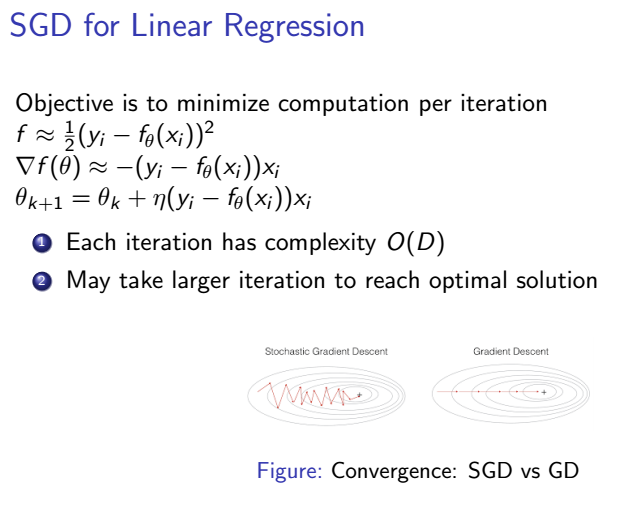

# Stochastic gradient descent

eta: 0.023842651154470294
SGD finished after 9999 iterations


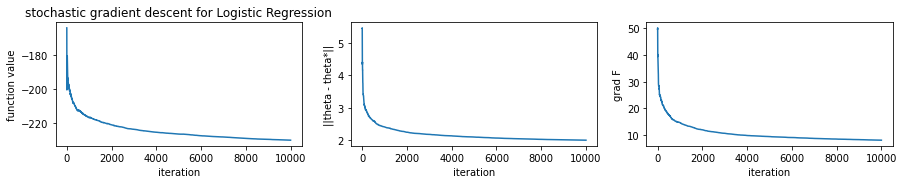

In [8]:
def stochastic_gradient_descent(model, eta, batch_size=1, max_iterations=1e4,
                                epsilon=1e-5, theta_start=None, seed=None):
    """
    Stochastic gradient with linearly decaying learning rate

    Parameters
    ----------
    model: optimization model object
    eta: learning rate
    batch_size: mini-batch size
    max_iterations: maximum number of gradient iterations
    epsilon: tolerance for stopping condition
    theta_start: where to start (otherwise random)

    Output
    ------
    solution: final theta value
    theta_history: theta values from each iteration
    """
    if seed:
        np.random.seed(seed)

    # data from model
    n = model.n  # number of data points
    d = model.d  # number of varaibles

    # gradient of single likelihood
    grad_f = model.grad_f
    F = model.F

    # initialization
    if theta_start:
        theta_current = theta_start
    else:
        theta_current = np.random.normal(loc=0, scale=1, size=d)

    # history
    theta_history = []

    for k in range(int(max_iterations)):

        theta_history.append(theta_current)

        # compute gradient estimate
        index = np.random.choice(n, batch_size)
        batch_grad = np.mean([grad_f(theta_current, i) for i in index], axis=0)

        # gradient update
        theta_next = theta_current - eta/(k + 1.0)*batch_grad

        # relative error stoping condition
        if np.linalg.norm(theta_next - theta_current) <= epsilon*np.linalg.norm(theta_current):
            break

        theta_current = theta_next

    print ('SGD finished after ' + str(k) + ' iterations')

    return {'solution': theta_current,
            'theta_history': theta_history}

#%%time
opt_algo = 'stochastic gradient descent'

eta = 2/model.L_F

print ('eta: ' + str(eta))
SGD_theta = stochastic_gradient_descent(model, eta, epsilon=1e-10)['theta_history']
print
plot_opt_path(SGD_theta, model, theta_solution, opt_algo)

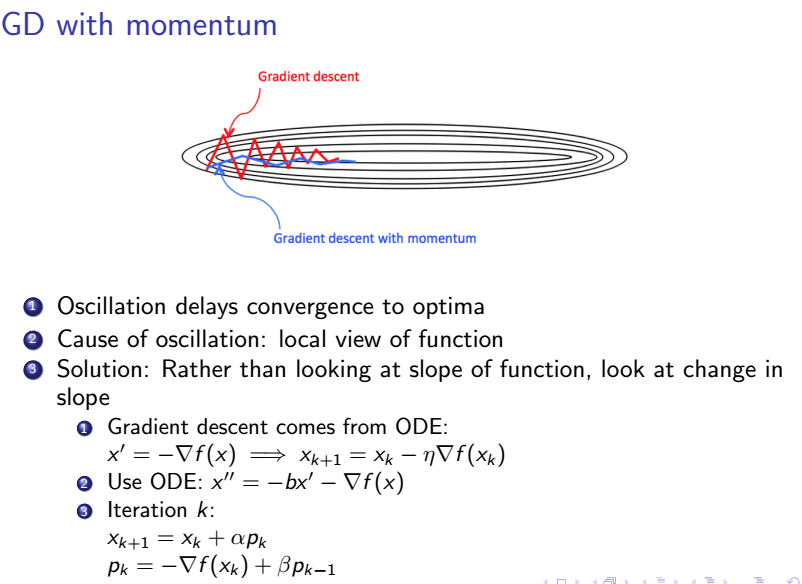

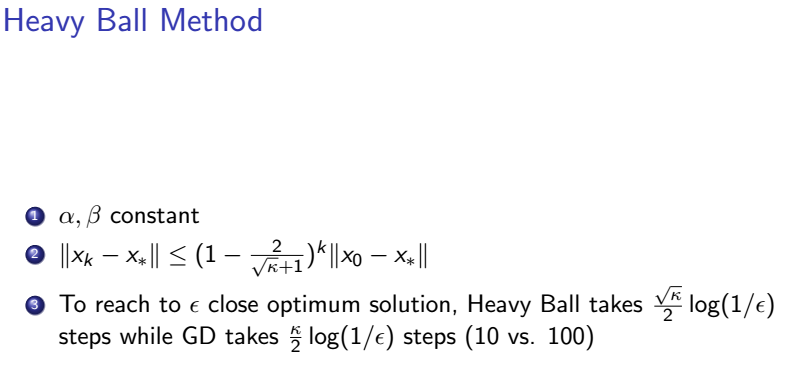

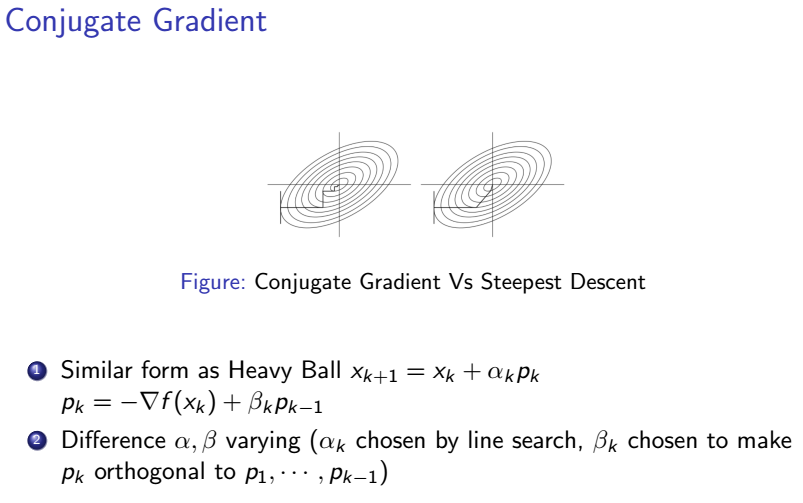

/home/jupyter/libraries/nb_env/lib64/python3.6/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/jupyter/libraries/nb_env/lib64/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: The following kwargs were not used by contour: 'shading'


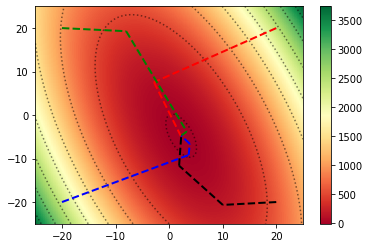

In [9]:
#!/usr/bin/env python

#
# Purpose: Show principle of conjugate-gradient optimization 
#          using interpolation strategy for the line search
#
# Author: Ivo Filot
# 

import numpy
import matplotlib.pylab as plt
import math

#
# Define a two-variable function and its gradient
#
def f(x):
	return 3.0*x[0]**2 + 2.0*x[0]*x[1] + x[1]**2 - 4.0*x[0] + 5.0*x[1]

def grad(x):
	return numpy.array([6.0 * x[0] + 2.0 * x[1] - 4.0,
	        2.0*x[0] + 2.0*x[1]+5.0])


#
# Draw heatmap of function f(x)
#
x1 = numpy.linspace(-25,25, 400)
x2 = numpy.linspace(-25,25, 400)
X,Y = numpy.meshgrid(x1, x2)
z = f([X,Y])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.pcolormesh(X, Y, z, cmap='RdYlGn')
plt.colorbar()
plt.contour(X, Y, z, colors="black", alpha=0.5, linestyles="dotted", shading="auto")

def line_search_interpolation(g, h, a0, p):
	"""
	@brief      perform line search using interpolation strategy
	
	@param      g     gradient vector
	@param      h     search vector
	@param      a0    starting distance
	@param      p     starting position
	
	@return     optimal a value
	"""
	deriv = numpy.dot(g,h)

	e0 = f(p)

	e1 = f(p + a0 * h)
	p1 = p + a0 * h


	if e1 < e0 + 1e-4 * a0 * deriv:
		return a0

	a1 = -deriv * a0 * a0 / (2.0 * (e1 - e0 - deriv * a0))
	e2 = f(p + a1 * h)
	p2 = p + a1 * h


	if e2 < e0 + 1e-4 * a1 * deriv:
		return a1

	a = 1.0 / (a0 * a0 * a1 * a1 * (a1 - a0)) * (a0 * a0 * (e2 - e0 - deriv * a1) - a1 * a1 * (e1 - e0 - deriv * a0))
	b = 1.0 / (a0 * a0 * a1 * a1 * (a1 - a0)) * (-a0 * a0 * a0 * (e2 - e0 - deriv * a1) + a1 * a1 * a1 * (e1 - e0 - deriv * a0))
	a2 = -b + math.sqrt(b * b - 3.0 * a * deriv) / (3.0 * a);
	if a2 < 0:
		a2 = a1 / 2.0
	e3 = f(p + a2 * h)
	p3 = p + a2 * h


	if e3 < e0 + 1e-4 * a2 * deriv:
		return a2

	return 0.0

def conjugate_gradient(p, color):
	"""
	@brief      conjugate gradient optimization
	
	@param      p      starting point
	@param      color  color to display search trajectory
	
	@return     void
	"""
	iter = 0
	g = grad(p)
	h = -g / numpy.linalg.norm(g)
	eold = f(p)
	pold = numpy.copy(p)
	maxlinesearch = 2.0

	while(iter < 100):
		a = line_search_interpolation(g, h, maxlinesearch, p)
		mp = p + maxlinesearch * h

		# check angle between two vectors
		g1 = grad(p + a * h)
		angle = math.acos(numpy.dot(-g1,h) / (numpy.linalg.norm(g1) * numpy.linalg.norm(h)))
		#print ("%12.8f" % angle)

		p += a * h

		enew = f(p)
		dif = math.fabs(enew - eold)
		if dif < 1e-4:
			#print  ("Done")
			break
		
		eold = enew

		if angle > (math.pi / 4):
			# perform cj step
			#print ("Angle larger than 45 deg, perform conjugate gradient step")

			oldg = numpy.copy(g)
			g = grad(p)
			beta = numpy.dot(g,g - oldg) / numpy.dot(oldg,oldg);
			h = -g + beta * h

			plt.plot([pold[0], p[0]], [pold[1], p[1]], linestyle="dashed", linewidth=2, color=color)

			pold = numpy.copy(p)
		
		iter +=1 

conjugate_gradient([20,20], 'red')
conjugate_gradient([-20,20], 'green')
conjugate_gradient([-20,-20], 'blue')
conjugate_gradient([20,-20], 'black')

plt.show()

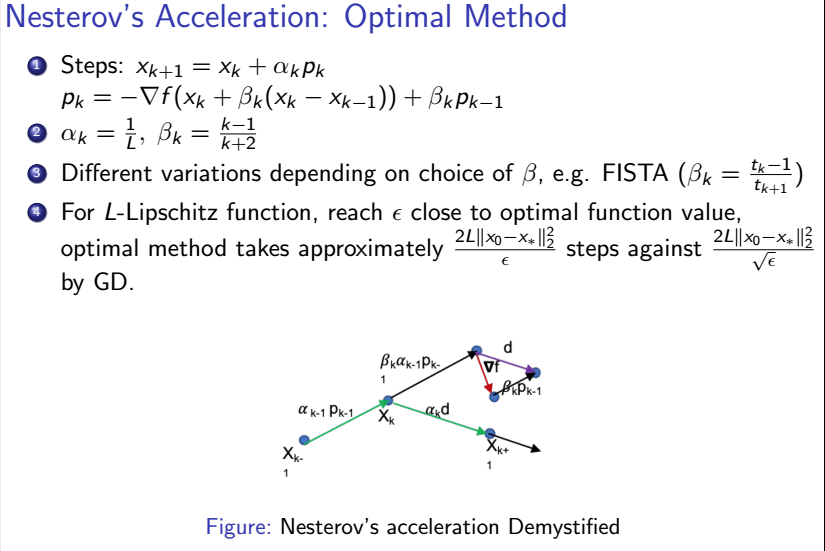

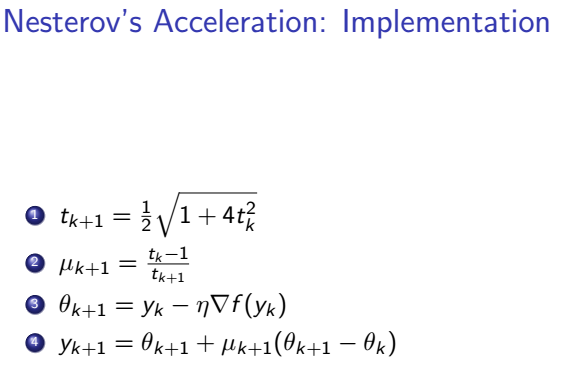

eta: 0.011921325577235147
accelerated GD finished after 82 iterations


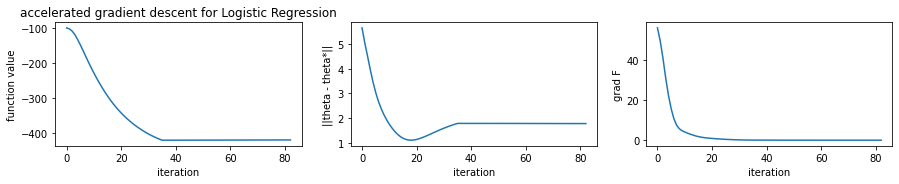

In [10]:
def accelerated_gradient_descent(model, eta, max_iterations=1e4, epsilon=1e-5,
                                 theta_start=None):
    """
    Nesterov's accelerated gradient descent

    Parameters
    ----------
    model: optimization model object
    eta: learning rate
    max_iterations: maximum number of gradient iterations
    epsilon: tolerance for stopping condition
    theta_start: where to start (otherwise random)

    Output
    ------
    solution: final theta value
    theta_history: theta values from each iteration
    """

    # data from model
    grad_F = model.grad_F
    d = model.d
    # F = model.F

    # initialization
    if theta_start:
        theta_current = theta_start
    else:
        theta_current = np.random.normal(loc=0, scale=1, size=d)

    y_current = theta_current
    t_current = 1.0

    # history
    theta_history = []

    for k in range(int(max_iterations)):
        # history
        theta_history.append(theta_current)

        # gradient update
        t_next = .5*(1 + np.sqrt(1 + 4*t_current**2))
        theta_next = y_current - eta * grad_F(y_current)
        y_next = theta_next + (t_current - 1.0)/(t_next)*(theta_next - theta_current)

        # relative error stoping condition
        if np.linalg.norm(theta_next - theta_current) <= epsilon*np.linalg.norm(theta_current):
            break
            # if np.linalg.norm(theta_next) <= epsilon:

        # restarting strategies
        if np.dot(y_current - theta_next, theta_next - theta_current) > 0:
            y_next = theta_next
            t_next = 1
            # if k %% k_restart == 0:

        theta_current = theta_next
        y_current = y_next
        t_current = t_next

    print ('accelerated GD finished after ' + str(k) + ' iterations')

    return {'solution': theta_current,
            'theta_history': theta_history}


#%time
opt_algo = 'accelerated gradient descent'

eta = 1/model.L_F

print ('eta: ' + str(eta))
AGD_theta = accelerated_gradient_descent(model, eta)['theta_history']
print
plot_opt_path(AGD_theta, model, theta_solution, opt_algo)



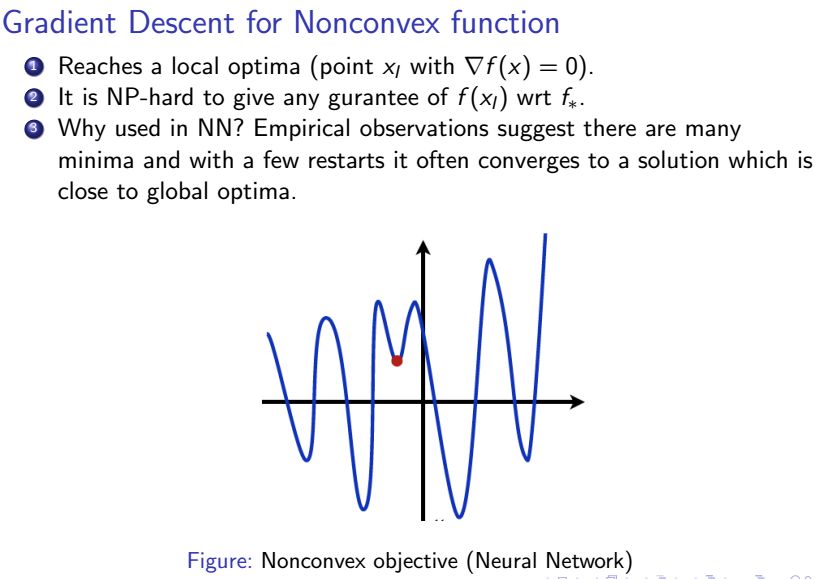

In [11]:
class NeuralNetwork:
    def __init__(self, i,h,o):
        np.random.seed(10) # for generating the same results
        self.wij   = np.random.rand(i,h) # input to hidden layer weights
        self.wjk   = np.random.rand(h,o) # hidden layer to output weights
        
    def sigmoid(self, x, w):
        z = np.dot(x, w)
        return 1/(1 + np.exp(-z))
    
    def sigmoid_derivative(self, x, w):
        return self.sigmoid(x, w) * (1 - self.sigmoid(x, w))
    
    def gradient_descent(self, x, y, iterations):
        for i in range(iterations):
            Xi = x
            Xj = self.sigmoid(Xi, self.wij)
            yhat = self.sigmoid(Xj, self.wjk)
            # gradients for hidden to output weights
            g_wjk = np.dot(Xj.T, (y - yhat) * self.sigmoid_derivative(Xj, self.wjk))
            # gradients for input to hidden weights
            g_wij = np.dot(Xi.T, np.dot((y - yhat) * self.sigmoid_derivative(Xj, self.wjk), self.wjk.T) * self.sigmoid_derivative(Xi, self.wij))
            # update weights
            self.wij += g_wij
            self.wjk += g_wjk
        print('The final prediction from neural network are: ')
        print(yhat)
i=5
h=6
o=1
neural_network = NeuralNetwork(i,h,o)
print('Random starting input to hidden weights: ')
print(neural_network.wij)
print('Random starting hidden to output weights: ')
print(neural_network.wjk)
X=np.random.randint(5, size=(h, i))
y=np.random.randint(2, size=(1, h)).T


neural_network.gradient_descent(X, y, 10000)

Random starting input to hidden weights: 
[[0.77132064 0.02075195 0.63364823 0.74880388 0.49850701 0.22479665]
 [0.19806286 0.76053071 0.16911084 0.08833981 0.68535982 0.95339335]
 [0.00394827 0.51219226 0.81262096 0.61252607 0.72175532 0.29187607]
 [0.91777412 0.71457578 0.54254437 0.14217005 0.37334076 0.67413362]
 [0.44183317 0.43401399 0.61776698 0.51313824 0.65039718 0.60103895]]
Random starting hidden to output weights: 
[[0.8052232 ]
 [0.52164715]
 [0.90864888]
 [0.31923609]
 [0.09045935]
 [0.30070006]]
The final prediction from neural network are: 
[[0.99700742]
 [0.99706282]
 [0.99708359]
 [0.99671999]
 [0.00721465]
 [0.99614137]]


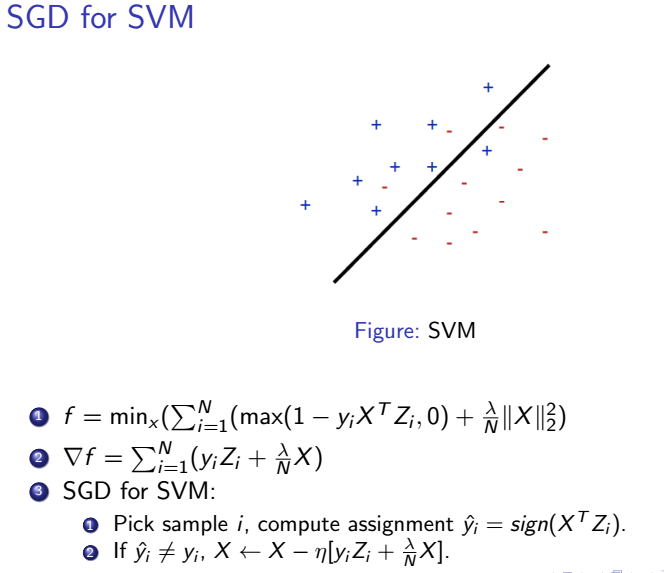

eta: 0.011921325577235147
theta_current shape (10,)
GD finished after 623 iterations
eta: 0.023842651154470294
SGD finished after 953 iterations


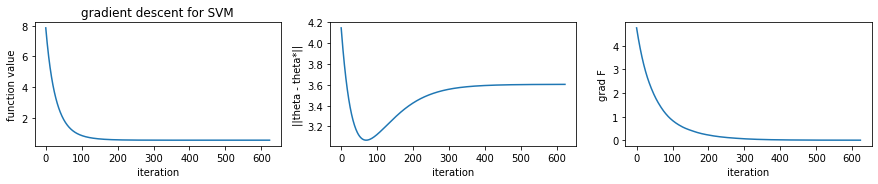

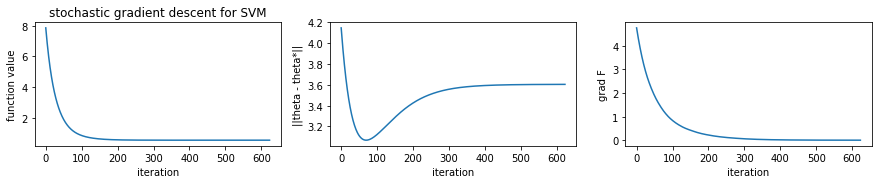

In [12]:
class SVM(object):
    """
    Hinge Loss

    min_x sum_i max(1-yX^T.beta, 0)+ lamda*|beta|^2
    x in R^d
    """

    def __init__(self, X, y, lamda):

        # data
        self.X = X
        self.y = y
        self.name="SVM"

        self.d = X.shape[1]
        self.n = X.shape[0]
        self.lamda=lamda

        # lipshitz constant
        self.L_F = .25 * np.linalg.norm(np.dot(X.T, X))

    def F(self, beta):
        n = self.y.shape[0]
        yx = self.y[:,np.newaxis]*self.X
        loss = np.maximum(0,1 - yx@beta)
        return 1/n * (np.sum(loss**2)) + (self.lamda * (np.linalg.norm(beta)**2))

    def grad_F(self, beta):
        n = y.shape[0]
        yx =  self.y[:,np.newaxis]*self.X
        loss = np.maximum(0,1 - yx@beta)
        return (-2/n)*loss@yx + 2*self.lamda*beta


    def f(self, beta, i):
        n = self.y.shape[0]
        yx = self.y[i,np.newaxis]*self.X[i,:]
        loss = np.maximum(0,1 - yx@beta)
        return (loss**2) + (self.lamda * (np.linalg.norm(beta)**2))

    def grad_f(self, beta, i):
        n = y.shape[0]
        yx =  self.y[i,np.newaxis]*self.X[i,:]
        loss = np.maximum(0,1 - yx@beta)
        return -2*loss + 2*self.lamda*beta


#generate instance 
n = 100
d = 10
X, y, theta_solution = generate_logreg_data(n, d, seed=34234)

# set up model
lamda=0.2
model = SVM(X, y,lamda)


opt_algo = 'gradient descent'

eta = 1/model.L_F

print( 'eta: ' + str(eta))

GD_theta = gradient_descent(model, eta)['theta_history']
print
plot_opt_path(GD_theta, model, theta_solution, opt_algo)

opt_algo = 'stochastic gradient descent'

eta = 2/model.L_F

print ('eta: ' + str(eta))
SGD_theta = stochastic_gradient_descent(model, eta)['theta_history']
print
plot_opt_path(GD_theta, model, theta_solution, opt_algo)

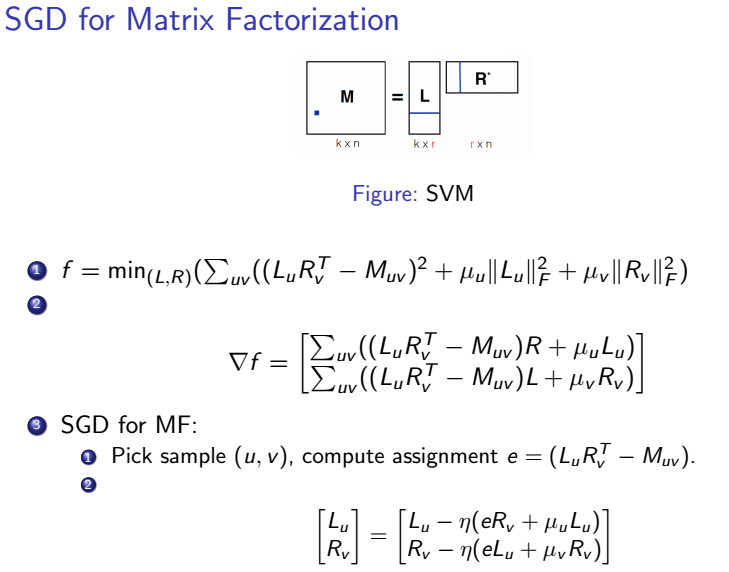

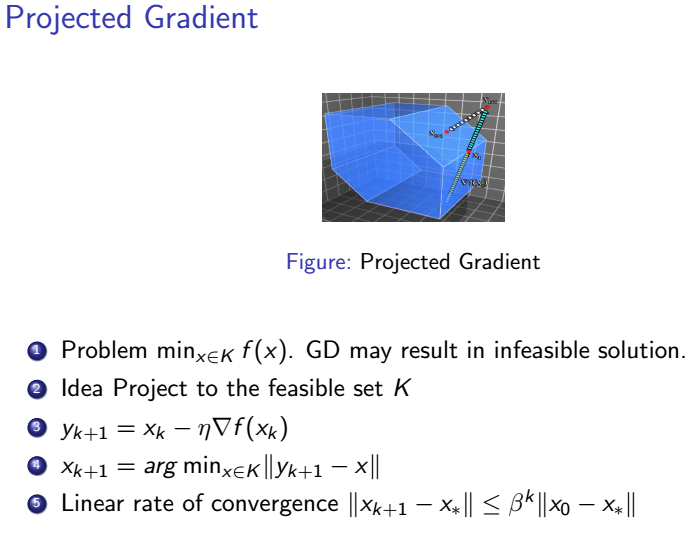

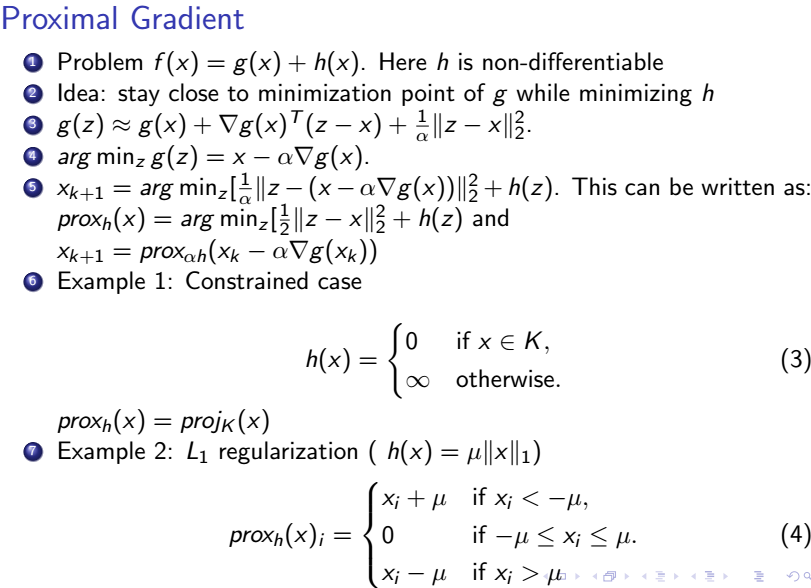

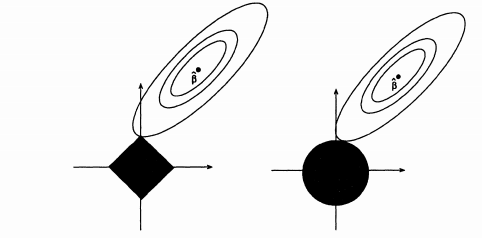

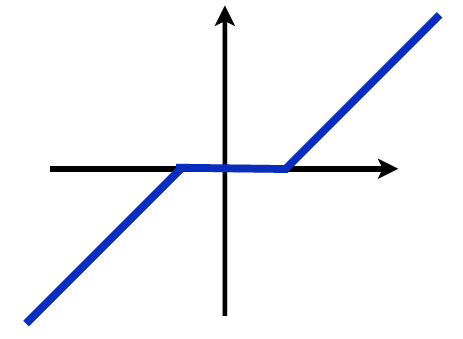

k: 0  obj =  [[183204.1449935]] Change =  510986.25101420155


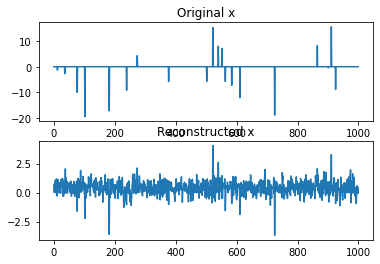

k: 1  obj =  [[85644.856439]] Change =  97559.28855450182


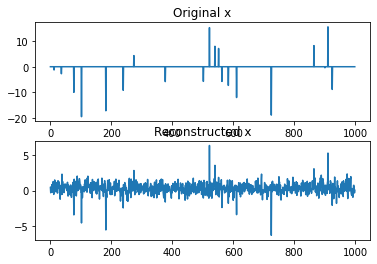

k: 2  obj =  [[68465.98601803]] Change =  17178.870420973573


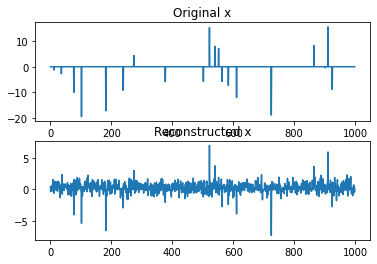

k: 3  obj =  [[61136.44115757]] Change =  7329.544860457099


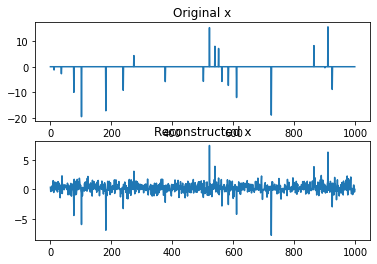

k: 4  obj =  [[57250.45365297]] Change =  3885.987504598037


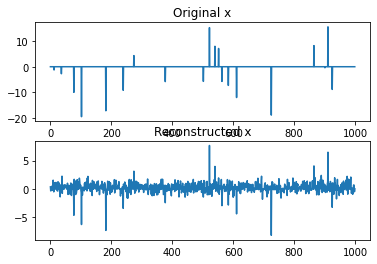

k: 5  obj =  [[53109.26859461]] Change =  4141.185058360912


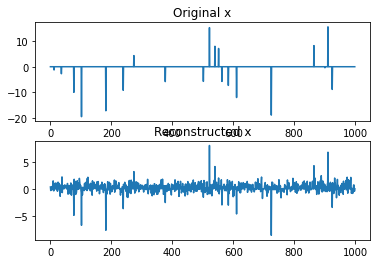

k: 6  obj =  [[51067.84699387]] Change =  2041.4216007430077


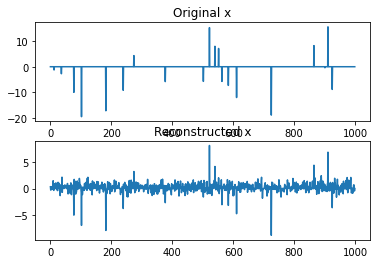

k: 7  obj =  [[48449.15793466]] Change =  2618.6890592113414


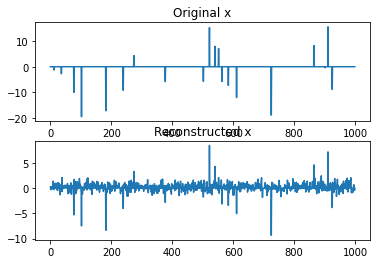

k: 8  obj =  [[46705.21080801]] Change =  1743.9471266439068


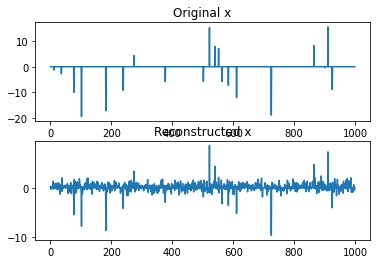

k: 9  obj =  [[45142.1954676]] Change =  1563.015340410624


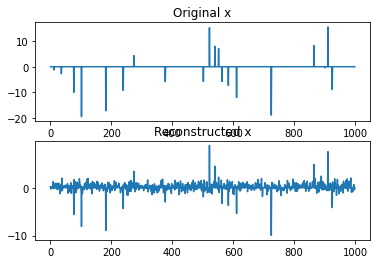

k: 10  obj =  [[43707.99924105]] Change =  1434.196226548942


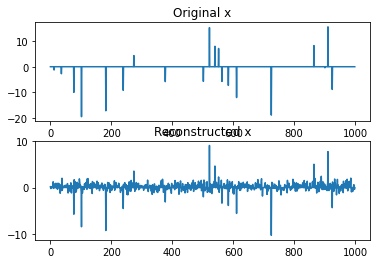

k: 11  obj =  [[42370.59148859]] Change =  1337.4077524619279


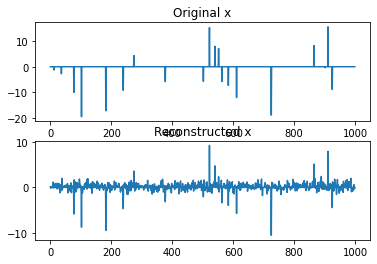

k: 12  obj =  [[41127.21136099]] Change =  1243.3801276005106


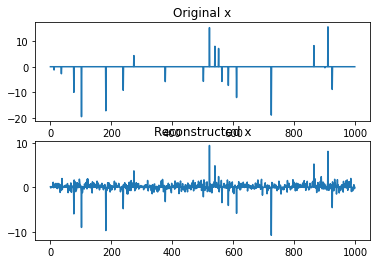

k: 13  obj =  [[39961.14426955]] Change =  1166.0670914428702


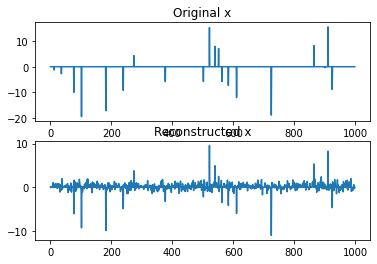

k: 14  obj =  [[38862.68508764]] Change =  1098.4591819091002


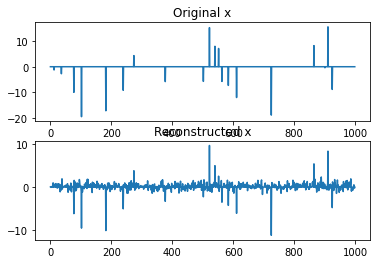

k: 15  obj =  [[37822.6914231]] Change =  1039.9936645362686


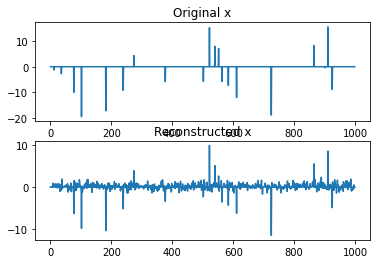

k: 16  obj =  [[36841.03099888]] Change =  981.6604242250687


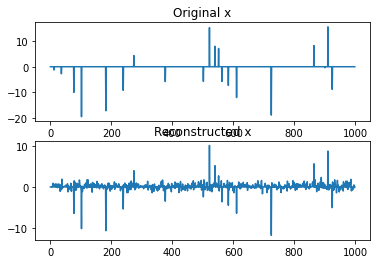

k: 17  obj =  [[35910.76040683]] Change =  930.2705920415101


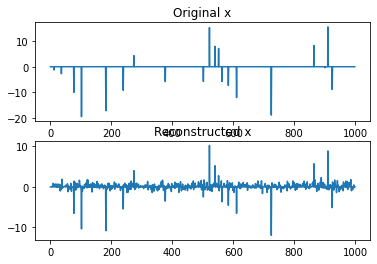

k: 18  obj =  [[35022.9405028]] Change =  887.8199040387917


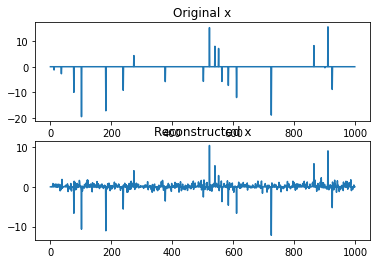

k: 19  obj =  [[34186.18086152]] Change =  836.7596412774801


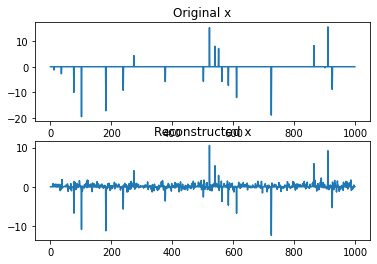

k: 20  obj =  [[33397.13267795]] Change =  789.0481835641331


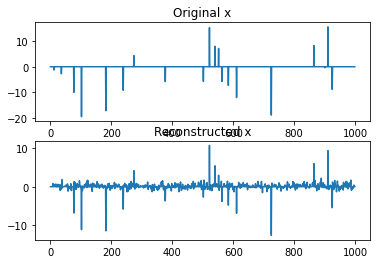

k: 21  obj =  [[32648.70178629]] Change =  748.4308916688133


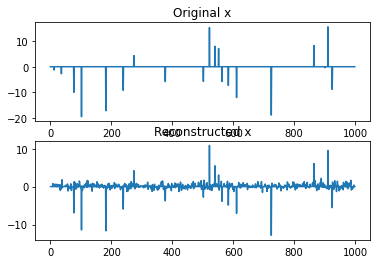

k: 22  obj =  [[31933.95509623]] Change =  714.7466900586805


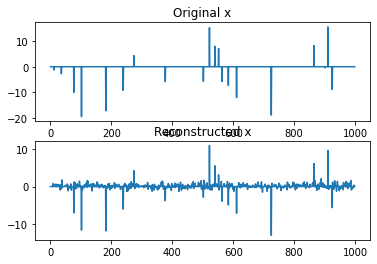

k: 23  obj =  [[31250.1696685]] Change =  683.785427721974


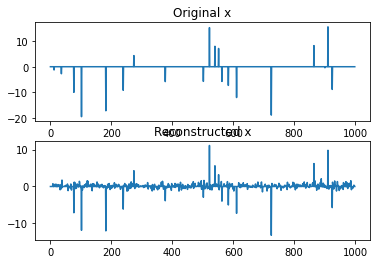

k: 24  obj =  [[30594.88300559]] Change =  655.2866629130585


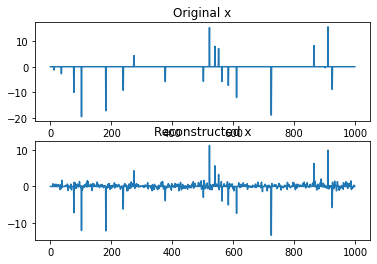

k: 25  obj =  [[29961.02426742]] Change =  633.8587381727484


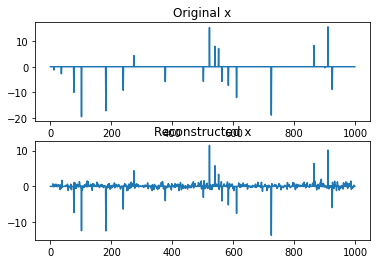

k: 26  obj =  [[29348.00698227]] Change =  613.0172851454663


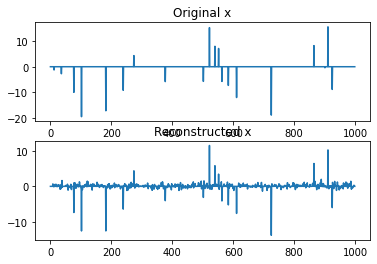

k: 27  obj =  [[28750.33965512]] Change =  597.6673271523359


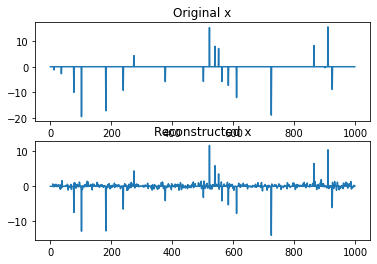

k: 28  obj =  [[28169.60808505]] Change =  580.7315700719555


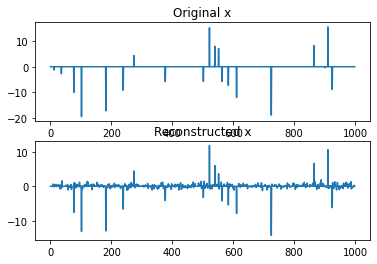

k: 29  obj =  [[27602.59349139]] Change =  567.0145936571207


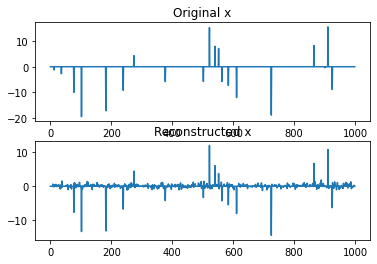

k: 30  obj =  [[27046.08011377]] Change =  556.5133776260227


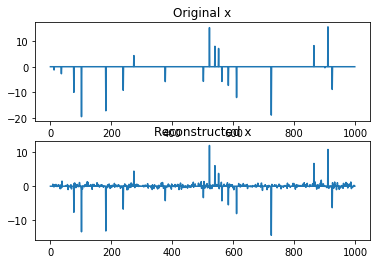

k: 31  obj =  [[26498.6331296]] Change =  547.4469841703612


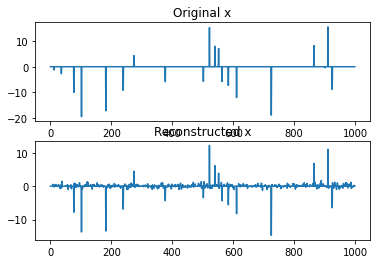

k: 32  obj =  [[25959.67046194]] Change =  538.9626676571497


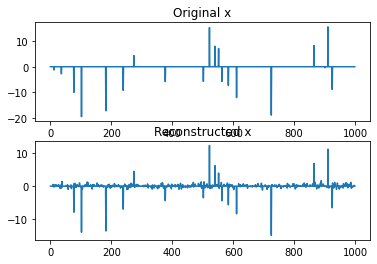

k: 33  obj =  [[25428.89921603]] Change =  530.7712459123759


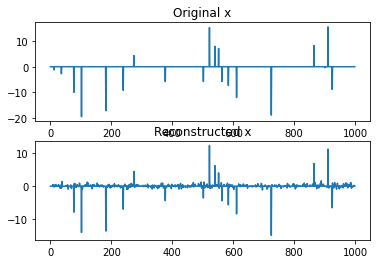

k: 34  obj =  [[24910.65637078]] Change =  518.2428452499298


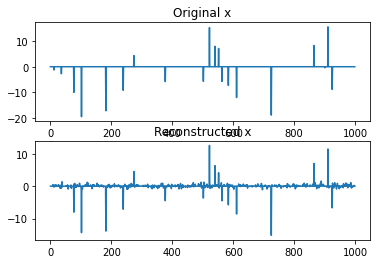

k: 35  obj =  [[24403.50109975]] Change =  507.1552710239557


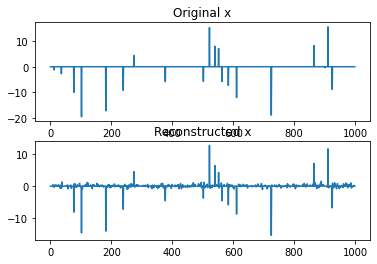

k: 36  obj =  [[23907.33833295]] Change =  496.1627667994544


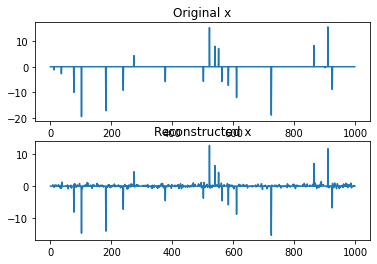

k: 37  obj =  [[23422.66244653]] Change =  484.6758864219737


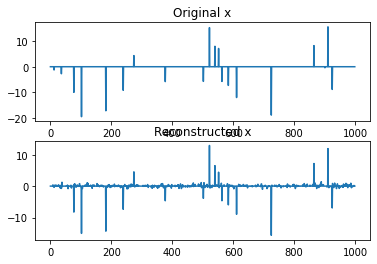

k: 38  obj =  [[22947.58540818]] Change =  475.0770383511517


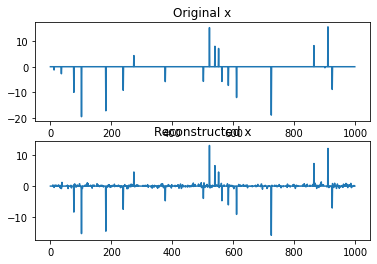

k: 39  obj =  [[22482.11617458]] Change =  465.46923360443907


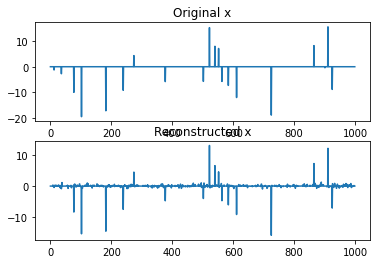

k: 40  obj =  [[22027.771176]] Change =  454.3449985782754


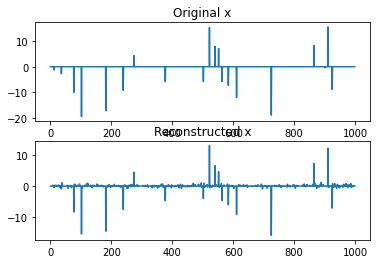

k: 41  obj =  [[21583.5444815]] Change =  444.22669449444584


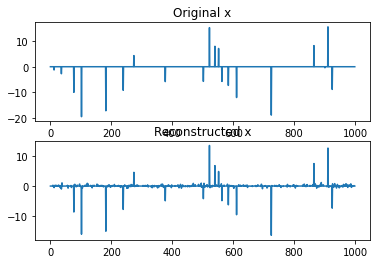

k: 42  obj =  [[21148.12828893]] Change =  435.4161925764638


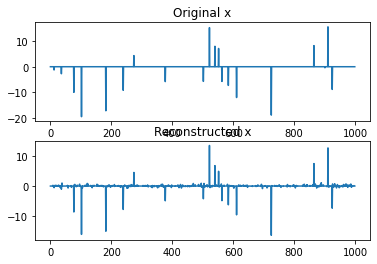

k: 43  obj =  [[20828.46949847]] Change =  319.6587904539738


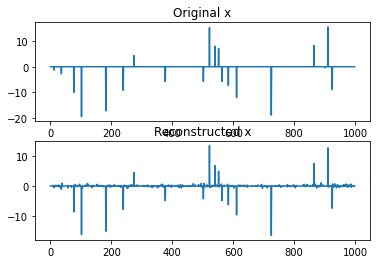

k: 44  obj =  [[20514.35116801]] Change =  314.11833046472384


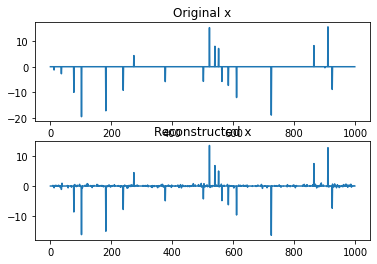

k: 45  obj =  [[20205.2380873]] Change =  309.1130807029258


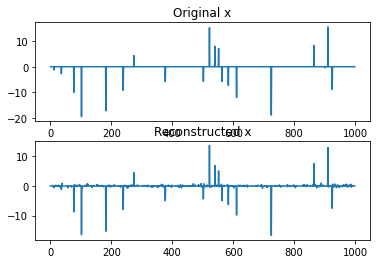

k: 46  obj =  [[19901.55709256]] Change =  303.68099474899645


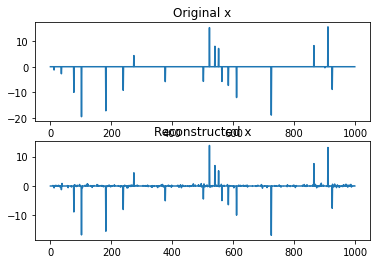

k: 47  obj =  [[19603.52003199]] Change =  298.0370605701355


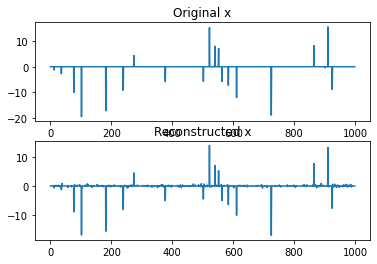

k: 48  obj =  [[19310.93800089]] Change =  292.58203109267924


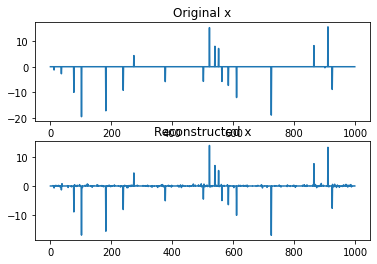

k: 49  obj =  [[19025.587909]] Change =  285.3500918970276


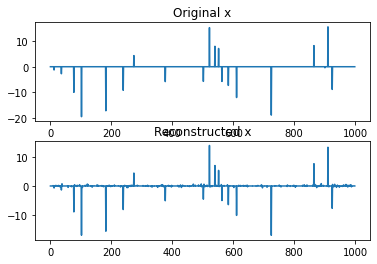

k: 50  obj =  [[18747.47711953]] Change =  278.1107894691413


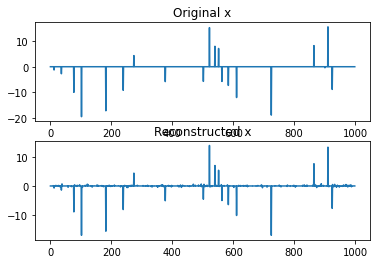

k: 51  obj =  [[18476.72485497]] Change =  270.7522645614263


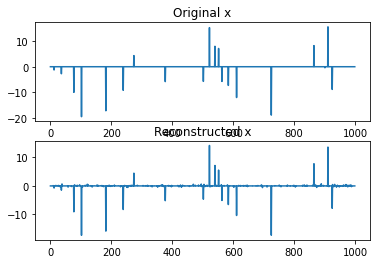

k: 52  obj =  [[18212.51175477]] Change =  264.2131001957787


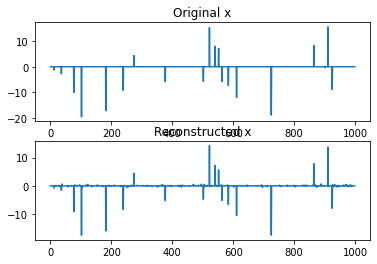

k: 53  obj =  [[17957.27119311]] Change =  255.24056165762158


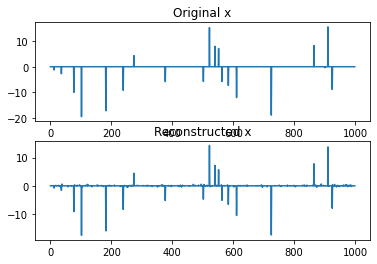

k: 54  obj =  [[17712.09942479]] Change =  245.17176831853067


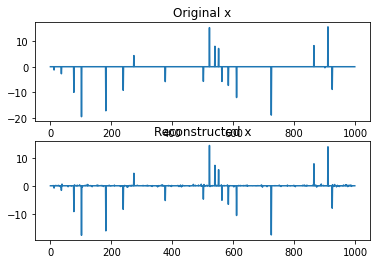

k: 55  obj =  [[17479.15514382]] Change =  232.9442809756947


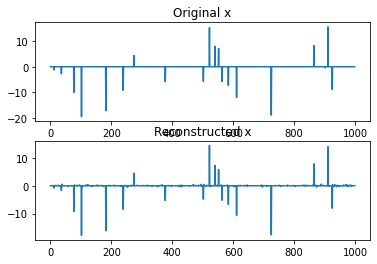

k: 56  obj =  [[17257.19164839]] Change =  221.96349542858297


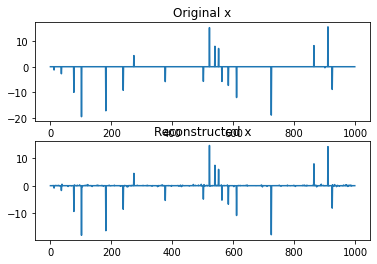

k: 57  obj =  [[17046.34660311]] Change =  210.84504528360776


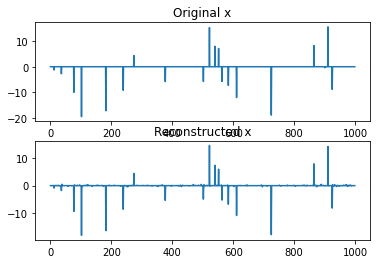

k: 58  obj =  [[16846.86157854]] Change =  199.48502456348433


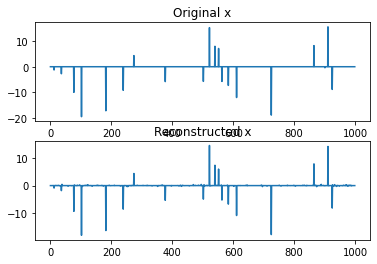

k: 59  obj =  [[16658.3310778]] Change =  188.53050074594285


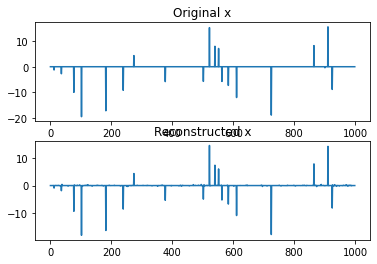

k: 60  obj =  [[16481.19341897]] Change =  177.13765882340886


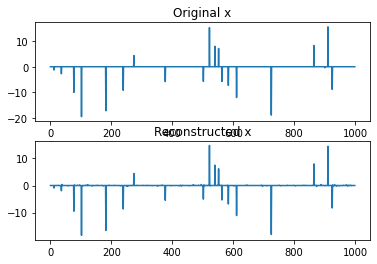

k: 61  obj =  [[16317.00544843]] Change =  164.18797053972048


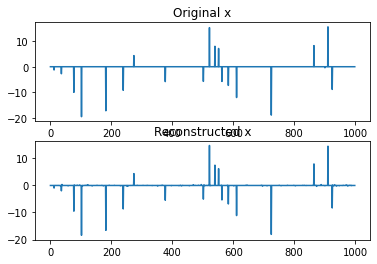

k: 62  obj =  [[16166.40169713]] Change =  150.60375130636385


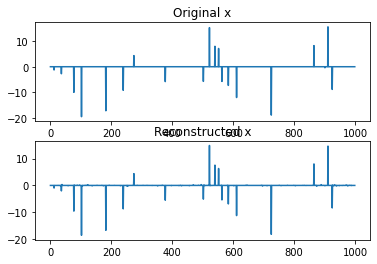

k: 63  obj =  [[16030.4158427]] Change =  135.98585443141383


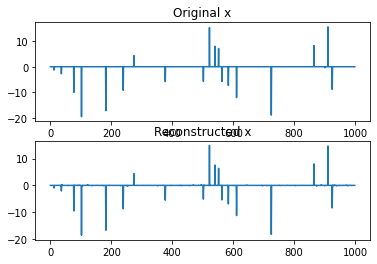

k: 64  obj =  [[15907.99061069]] Change =  122.42523200203323


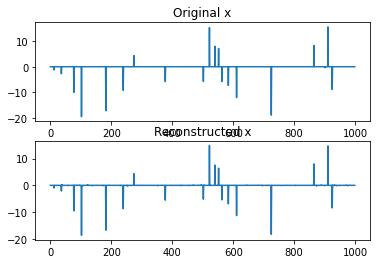

k: 65  obj =  [[15799.49912254]] Change =  108.49148815198896


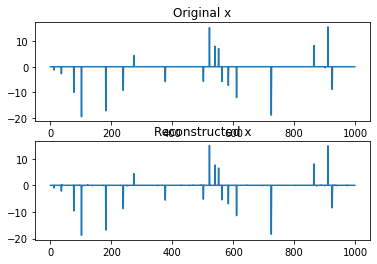

k: 66  obj =  [[15705.52735026]] Change =  93.97177227874272


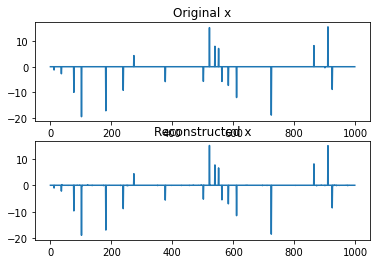

k: 67  obj =  [[15626.63210706]] Change =  78.8952431992875


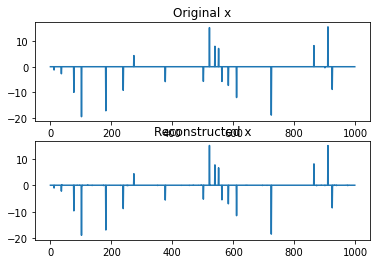

k: 68  obj =  [[15561.99187196]] Change =  64.64023510741026


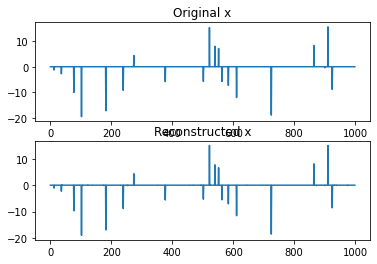

k: 69  obj =  [[15510.84252649]] Change =  51.1493454606516


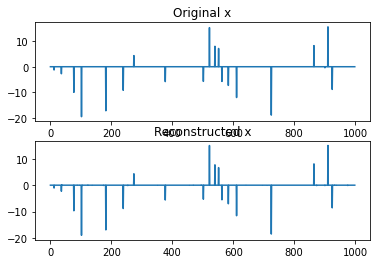

k: 70  obj =  [[15471.51172085]] Change =  39.33080564784905


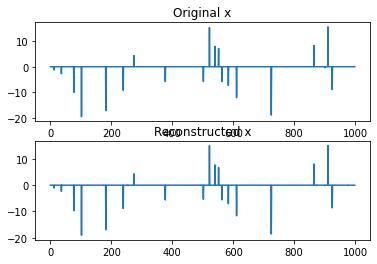

k: 71  obj =  [[15441.50265177]] Change =  30.009069078549146


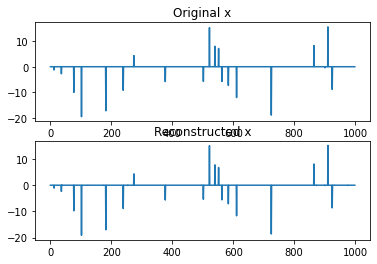

k: 72  obj =  [[15419.47705131]] Change =  22.025600458633562


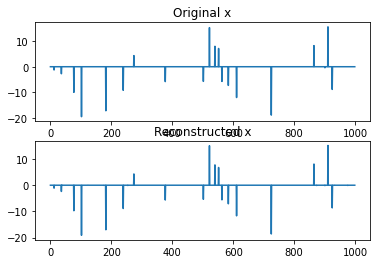

k: 73  obj =  [[15404.14442918]] Change =  15.332622133222685


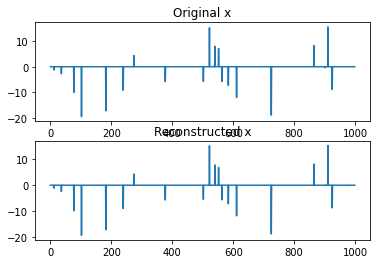

k: 74  obj =  [[15393.46520969]] Change =  10.679219483190536


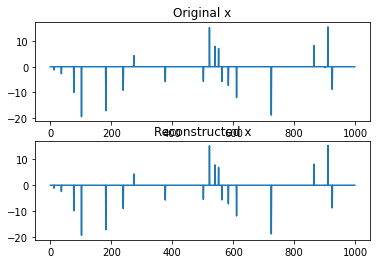

k: 75  obj =  [[15386.07156404]] Change =  7.393645654547072


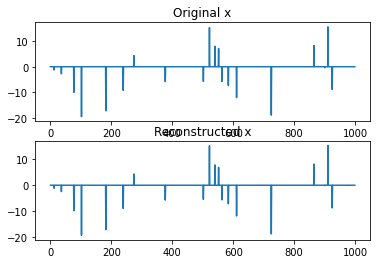

k: 76  obj =  [[15381.35906553]] Change =  4.712498505154144


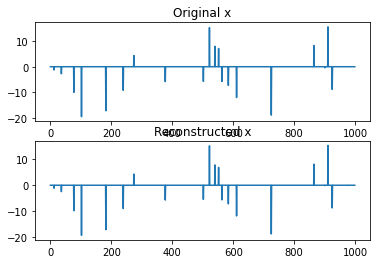

k: 77  obj =  [[15378.41151011]] Change =  2.9475554274958995


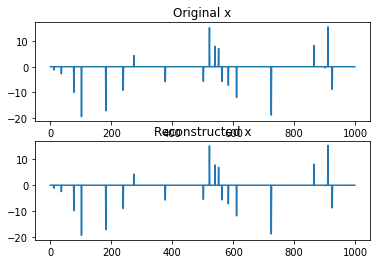

k: 78  obj =  [[15376.44035238]] Change =  1.9711577300404315


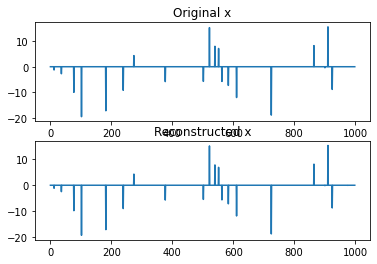

k: 79  obj =  [[15375.14433579]] Change =  1.2960165849581244


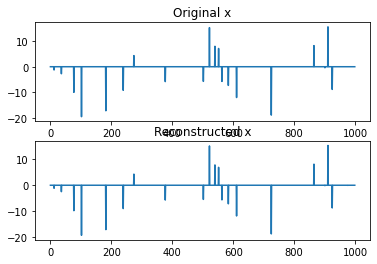

k: 80  obj =  [[15374.29715834]] Change =  0.8471774484514754


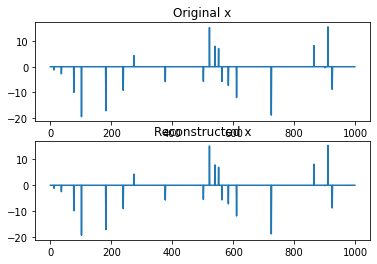

k: 81  obj =  [[15373.73245627]] Change =  0.5647020728138159


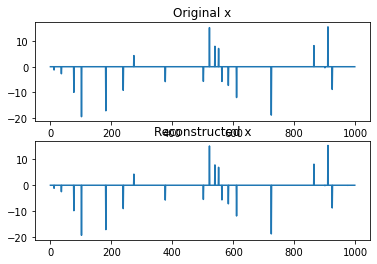

k: 82  obj =  [[15373.35118918]] Change =  0.38126708731942927


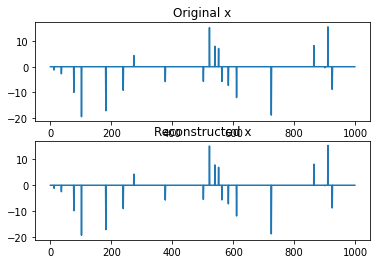

k: 83  obj =  [[15373.09262179]] Change =  0.25856739640767046


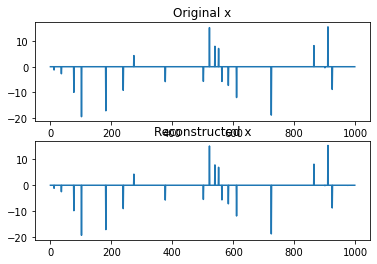

k: 84  obj =  [[15372.9233003]] Change =  0.16932149014428433


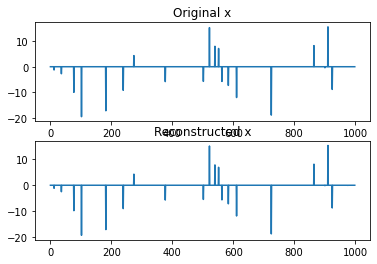

k: 85  obj =  [[15372.81981567]] Change =  0.10348462370347988


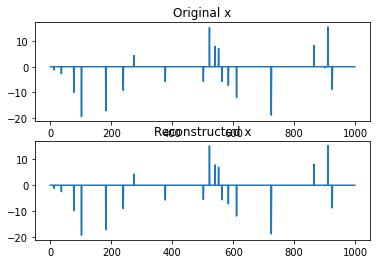

k: 86  obj =  [[15372.75508881]] Change =  0.06472685917469789


In [13]:
#Adapted from the following code
#@author: Md. Iftekhar Tanveer (itanveer@cs.rochester.edu)

import numpy as np
import matplotlib.pyplot as pp

# Objective function: f(x) + lambda*norm1(x)
def obj(A,x,b,lamda):
    assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0) and \
    np.size(x,1)== np.size(b,1) == 1 and np.isscalar(lamda))
    return f(A,x,b) + lamda*np.sum(np.abs(x))

# f(x) = (1/2)||Ax-b||^2
def f(A,x,b):
    assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0) and \
    np.size(x,1)== np.size(b,1) == 1)
    Ax_b = A.dot(x) - b
    return 0.5*(Ax_b.T.dot(Ax_b))

# gradient of f(x)= A'(Ax - b)   
def grf(A,x,b):
    assert(np.size(x,0)==np.size(A,1) and np.size(A,0) == np.size(b,0) and \
    np.size(x,1)== np.size(b,1) == 1)
    return A.T.dot(A.dot(x) - b)
    
# Model function evaluated at x and touches f(x) in xk
def m(x,xk,A,b,GammaK):
    assert(np.size(xk,0) == np.size(x,0) == np.size(A,1) \
    and np.size(A,0) == np.size(b,0) and \
    np.size(xk,1) == np.size(x,1) == np.size(b,1) == 1 and np.isscalar(GammaK))
    innerProd = grf(A,xk,b).T.dot(x - xk)
    xDiff = x - xk
    return f(A,xk,b) + innerProd + (1.0/(2.0*GammaK))*xDiff.T.dot(xDiff)

# Shrinkage or Proximal operation
def proxNorm1(y,lamda):
    assert(np.size(y,1)==1)
    return np.sign(y)*np.maximum(np.zeros(np.shape(y)),np.abs(y)-lamda)

def proximalGradient():
    # Define parameters. Size of A is n x p
    p = 1000
    n = 500
    kMax = 500   # Number of iteration
    beta = 0.75 # decreasing factor for line search
    # Generate the sparse vector xStar
    # and Randomly set 20 elements
    xStar = np.zeros((p,1))
    xStar[np.floor(p*np.random.rand(20,1)).astype(np.int)]=1
    xStar = xStar*np.random.normal(0,10,(p,1))

    # Generate A and b. b = Ax + error
    A = np.random.randn(n,p)
    b = A.dot(xStar) + np.random.randn(n,1)
    lamda = np.sqrt(2*n*np.log(p)).tolist()

   
    # Proximal Gradient Descent
    xk = np.random.rand(p,1) # Initialize with random

    
    for k in range(kMax):
        Gammak = 0.1    
        
        # Line search
        while True:
            x_kplus1 = xk - Gammak*grf(A,xk,b)        # Gradient Descent (GD) Step
            if f(A,x_kplus1,b) <= m(x_kplus1,xk,A,b,Gammak):
                break
            else:
                Gammak = beta*Gammak
        x_kplus1 = proxNorm1(x_kplus1,Gammak*lamda)   # Proximal Operation (Shrinkage)
        
        # Terminating Condition        
        Dobj = np.linalg.norm(obj(A,x_kplus1,b,lamda) - obj(A,xk,b,lamda))
        print ('k:',k, ' obj = ', obj(A,x_kplus1,b,lamda), 'Change = ',Dobj)
        if(Dobj<0.1):
            break

        # Update xk
        xk = x_kplus1 
        
        # Graphical Display        
        pp.figure(2)
        pp.clf()        
        pp.subplot(211)    
        pp.plot(xStar)
        pp.title('Original x')
        pp.subplot(212)
        pp.plot(xk)
        pp.title('Reconstructed x')
        pp.draw()
        pp.pause(0.1)
    pp.show()

proximalGradient()

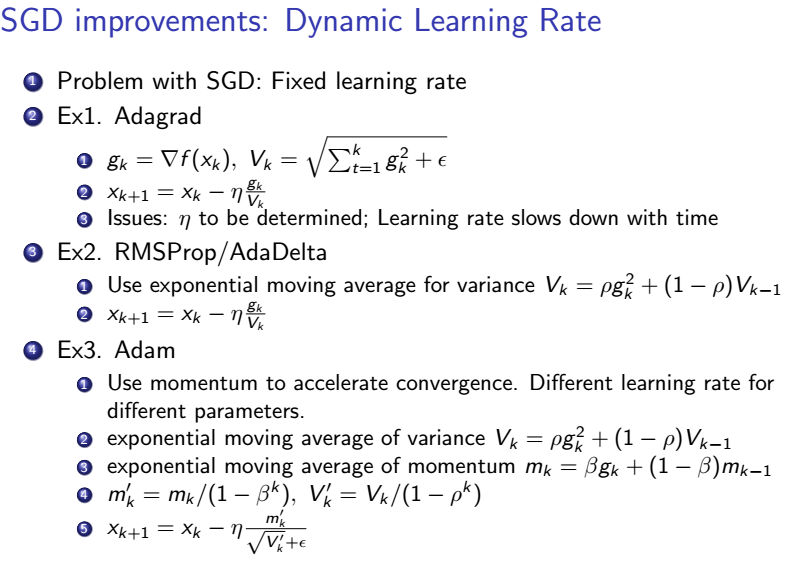

Loss after 0th epoch = 58.18187579879096

Loss after 1th epoch = 56.713381543112014

Loss after 2th epoch = 55.44812499639115

Loss after 3th epoch = 54.300897723972504

Loss after 4th epoch = 53.23909031797869

Loss after 5th epoch = 52.24815112477497

Loss after 6th epoch = 51.32107510486938

Loss after 7th epoch = 50.45420622661137

Loss after 8th epoch = 49.64530514270333

Loss after 9th epoch = 48.892602861759656

Loss after 10th epoch = 48.19434061800345

Loss after 11th epoch = 47.5485673566076

Loss after 12th epoch = 46.953077238644916

Loss after 13th epoch = 46.40542165805372

Loss after 14th epoch = 45.90295769847682

Loss after 15th epoch = 45.44291072448418

Loss after 16th epoch = 45.02243836088372

Loss after 17th epoch = 44.63868903194234

Loss after 18th epoch = 44.28885187190871

Loss after 19th epoch = 43.970196990472225

Loss after 20th epoch = 43.680106305224896

Loss after 21th epoch = 43.41609578808047

Loss after 22th epoch = 43.17583024812391

Loss after 23th 

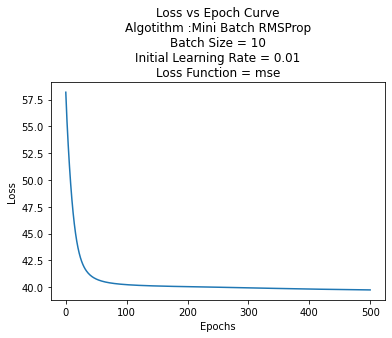

Loss after 0th epoch = -48.20899640003119

Loss after 1th epoch = -49.9620194952207

Loss after 2th epoch = -51.526071644611214

Loss after 3th epoch = -53.00484530198632

Loss after 4th epoch = -54.43969475665857

Loss after 5th epoch = -55.850505887680825

Loss after 6th epoch = -57.247718270252285

Loss after 7th epoch = -58.63705247193847

Loss after 8th epoch = -60.021698177651594

Loss after 9th epoch = -61.40343248159427

Loss after 10th epoch = -62.783227242040105

Loss after 11th epoch = -64.16159130243739

Loss after 12th epoch = -65.53876752434323

Loss after 13th epoch = -66.91484757377455

Loss after 14th epoch = -68.28983914073679

Loss after 15th epoch = -69.66370531076954

Loss after 16th epoch = -71.03638752292075

Loss after 17th epoch = -72.40781882398298

Loss after 18th epoch = -73.77793138387027

Loss after 19th epoch = -75.14666062393952

Loss after 20th epoch = -76.5139473556629

Loss after 21th epoch = -77.879738760145

Loss after 22th epoch = -79.2439887015237

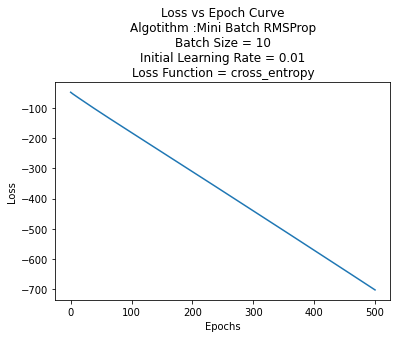

In [15]:
#RMSProp 
#Helper Functions
def f(x,w,b):
    '''Sigmoid Function'''
    f = 1/(1+np.exp(-(w*x+b)))
    return f
def mse(x,y,w,b):
    '''Mean Squared Loss Function'''
    L = 0.0
    for i in range(x.shape[0]):
        L += 0.5*(y[i]-f(x[i],w,b))**2
    return L
def cross_entropy(x,y,w,b):
    '''Cross Entropy Loss Function'''
    L = 0.0
    for i in range(x.shape[0]):
        L += -(y[i]*np.log(f(x[i],w,b)))
    return L
def grad_w_mse(x,y,w,b):
    fx = f(x,w,b) 
    dw = (fx - y)*fx*(1-fx)*x
    return dw
def grad_b_mse(x,y,w,b):
    fx = f(x,w,b) 
    db = (fx - y)*fx*(1-fx)
    return db
def grad_w_cross(x,y,w,b):
    fx = f(x,w,b) 
    dw = (- y)*(1-fx)*x
    return dw
def grad_b_cross(x,y,w,b):
    fx = f(x,w,b) 
    db = (- y)*(1-fx)
    return db

#Algorithm
#Gradient Discent
def RMSProp(x,y,epochs,batch_size,loss,lr):
    w = np.random.randn()
    b = np.random.randn()
    epsilon = 0.5
    beta = 0.95
    update_w, update_b = 0,0
    l_list = []
    w_list = []
    b_list = []
    points = 0
    ep = [i for i in range(epochs+1)]
    dw,db = 0,0
    for i in range(epochs+1):
        dw,db = 0,0
        for j in range(x.shape[0]):
            if (loss == 'mse'):
                dw += grad_w_mse(x[j],y[j],w,b)
                db += grad_b_mse(x[j],y[j],w,b)
            elif (loss == 'cross_entropy'):
                dw += grad_w_cross(x[j],y[j],w,b)
                db += grad_b_cross(x[j],y[j],w,b)
            points += 1
            if(points % batch_size == 0):
                update_w = beta * update_w + (1 - beta)* dw**2
                update_b = beta * update_b + (1- beta) * db**2 
                w = w - (lr/np.sqrt(update_w + epsilon))*dw
                b = b - (lr/np.sqrt(update_b + epsilon))*db
                dw,db = 0,0
        if (loss == 'mse'):
            print('Loss after {}th epoch = {}\n'.format(i,mse(x,y,w,b)[0]))
            l_list.append(mse(x,y,w,b)[0])
        elif (loss == 'cross_entropy'):
            print('Loss after {}th epoch = {}\n'.format(i,cross_entropy(x,y,w,b)[0]))
            l_list.append(cross_entropy(x,y,w,b)[0])
        w_list.append(w[0])
        b_list.append(b[0])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch Curve\nAlgotithm :Mini Batch RMSProp\nBatch Size = {}\nInitial Learning Rate = {}\nLoss Function = {}'.format(batch_size,lr,loss))
    plt.plot(ep,l_list)
    plt.show()
    return w_list,b_list


#generate instance 
n = 100
d = 10
X, y = generate_LS_data(n, d, seed=34234)


W,B = RMSProp(X,y,500,10,'mse',0.01)

#generate instance 
n = 100
d = 10
X, y, theta_solution = generate_logreg_data(n, d, seed=34234)

W,B = RMSProp(X,y,500,10,'cross_entropy',0.01)

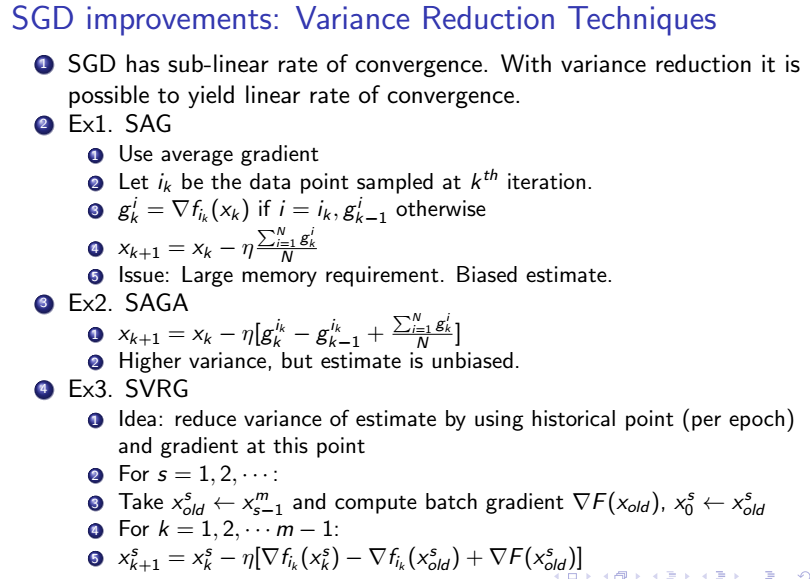

Objective function value is: 0.6053663828944768


Text(0, 0.5, 'Objective')

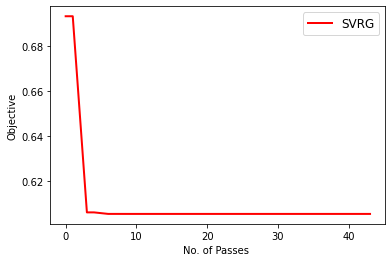

In [16]:
from scipy.special import expit as sigmoid
from sklearn.preprocessing import normalize

N = 10000
dim = 50
lamda = 1e-4
np.random.seed(1)
w = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim))).T
X = np.matrix(np.random.multivariate_normal([0.0]*dim, np.eye(dim), size = N))
X = np.matrix(normalize(X, axis=1, norm='l2'))
y = 2 * (np.random.uniform(size = (N, 1)) < sigmoid(X*w)) - 1



## Define the objective and gradient oracles. 
def obj(w):
    return 1/N * np.sum( np.log(1 + np.exp(-np.multiply(y, (X*w)))) ) + 1/2 * lamda * (w.T*w)

def grad(w,X,y):
    return 1/X.shape[0] * X.T * np.multiply( y, sigmoid(np.multiply(y, X*w)) - 1) + lamda*w

## SVRG
w = np.matrix([0.0]*dim).T
obj_SVRG = []
passes_SVRG = []

L = lamda + 1/4;
num_pass = 50

Epochs = 15
k = 2
batch = 50
for s in range(Epochs):
    obj_val = obj(w)
    obj_SVRG.append(obj_val.item())
    passes_SVRG.append(s*k+s)
    
    w_prev = w
    gradient = grad(w, X, y)

    obj_SVRG.append(obj_val.item())
    passes_SVRG.append(s*k+s+1)    
    
    max_iter = int(k*N/batch)
    for t in range(max_iter):
        rand_idx = np.random.randint(0, N-1, batch)
        yt = y[rand_idx, 0]
        xt = X[rand_idx, :]
        gamma = 1/L
        w = w - gamma * (grad(w,xt,yt) - grad(w_prev,xt,yt) + gradient)

print('Objective function value is: {}'.format(obj_SVRG[-1])) 

## Plot objective vs. iteration
t = passes_SVRG
plt.plot(t, np.array(obj_SVRG), 'r', linewidth = 2, label = 'SVRG')
plt.legend(prop={'size':12})
plt.xlabel('No. of Passes ')
plt.ylabel('Objective')



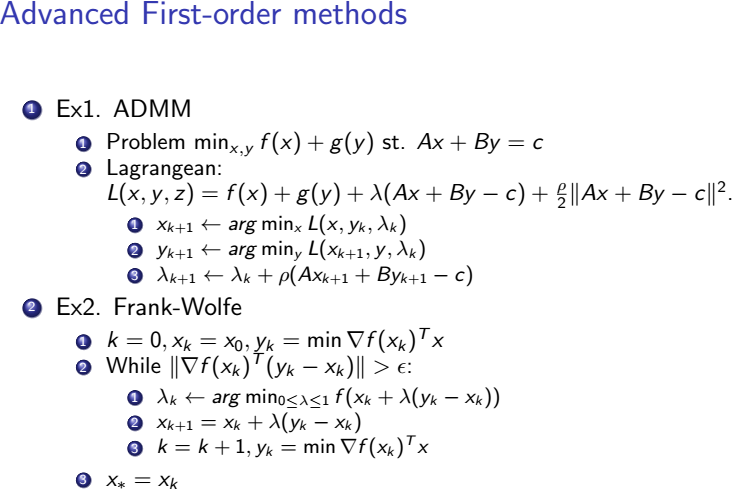

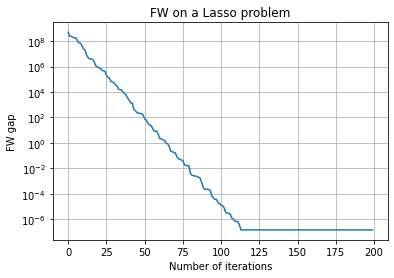

Sparsity of solution: 0.1%


In [17]:
from scipy import sparse
from sklearn import datasets

n_samples, n_features = 1000, 10000
A, b = datasets.make_regression(n_samples, n_features)


def FW(alpha, max_iter=200, tol=1e-8):
    # .. initial estimate, could be any feasible point ..
    x_t = sparse.dok_matrix((n_features, 1))
    trace = []  # to keep track of the gap

    # .. some quantities can be precomputed ..
    Atb = A.T.dot(b)
    for it in range(max_iter):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)

        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = alpha * np.sign(-grad[idx_oracle])
        g_t = x_t.T.dot(grad).ravel() - grad[idx_oracle] * mag_oracle
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t
        x_t[idx_oracle] = x_t[idx_oracle] + step_size * mag_oracle
    return x_t, np.array(trace)

# .. plot evolution of FW gap ..
sol, trace = FW(.5 * n_features)
plt.plot(trace)
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('FW gap')
plt.title('FW on a Lasso problem')
plt.grid()
plt.show()

sparsity = np.mean(sol.toarray().ravel() != 0)
print('Sparsity of solution: %s%%' % (sparsity * 100))

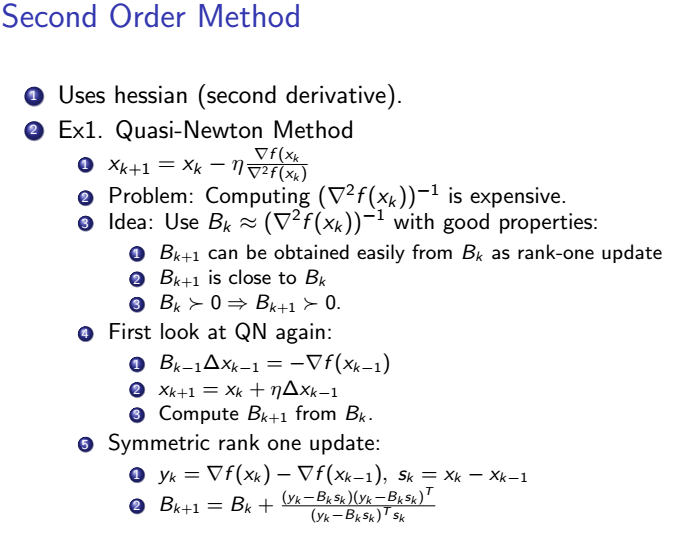

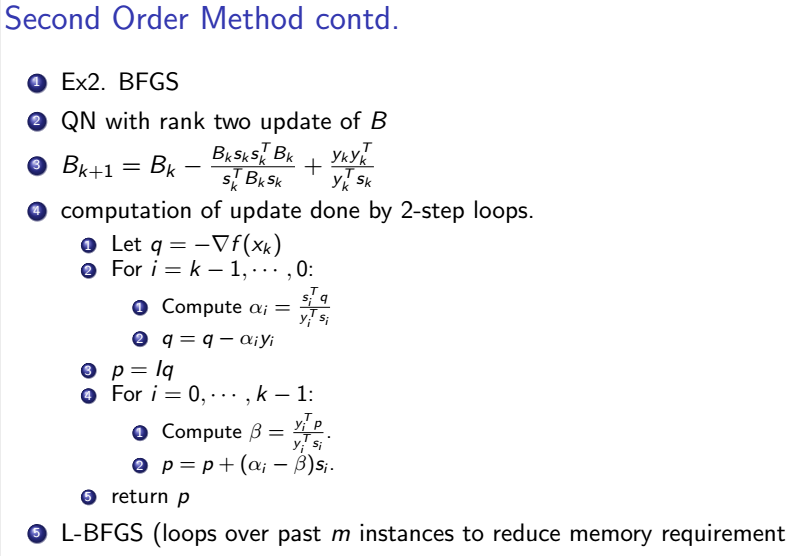

In [18]:
#Demo of l-bfgs 
#Adapted from the source given below:

"""l-bfgs-b L1-Logistic Regression solver"""

# Author: Vlad Niculae <vlad@vene.ro>
# Suggested by Mathieu Blondel

from __future__ import division, print_function

import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.extmath import safe_sparse_dot, log_logistic
from scipy.special import expit 
from time import time

def _l1_logistic_loss_grad(w_extended, X, y, alpha):
    _, n_features = X.shape
    w = w_extended[:n_features] - w_extended[n_features:]

    yz = y * safe_sparse_dot(X, w)

    # Logistic loss is the negative of the log of the logistic function.
    out = -np.sum(log_logistic(yz))
    # out += .5 * alpha * np.dot(w, w)  # L2
    out += alpha * w_extended.sum()  # L1, w_extended is non-negative

    z = expit(yz)
    z0 = (z - 1) * y

    grad = safe_sparse_dot(X.T, z0)
    grad = np.concatenate([grad, -grad])
    # grad += alpha * w  # L2
    grad += alpha  # L1

    return out, grad

class LbfgsL1Logistic(BaseEstimator, ClassifierMixin):

    def __init__(self, tol=1e-3, alpha=1.0):
        """Logistic Regression Lasso solved by L-BFGS-B
        Solves the same objective as sklearn.linear_model.LogisticRegression
        Parameters
        ----------
        alpha: float, default: 1.0
            The amount of regularization to use.
        tol: float, default: 1e-3
            Convergence tolerance for L-BFGS-B.
        """
        self.tol = tol
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape

        coef0 = np.zeros(2 * n_features)
        w, f, d = fmin_l_bfgs_b(_l1_logistic_loss_grad, x0=coef0, fprime=None,
                                pgtol=self.tol,
                                bounds=[(0, None)] * n_features * 2,
                                args=(X, y, self.alpha))
        self.coef_ = w[:n_features] - w[n_features:]

        return self

    def predict(self, X):
        return np.sign(safe_sparse_dot(X, self.coef_))


from scipy.spatial.distance import jaccard
# Generate data with known sparsity pattern
n_samples, n_features, n_relevant = 100, 80, 20
X = np.random.randn(n_samples, n_features)
X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
true_coef = np.zeros(n_features)
nonzero_idx = np.random.randint(n_features, size=n_relevant)
true_coef[nonzero_idx] = np.random.randn(n_relevant)
y = np.dot(X, true_coef) + np.random.randn(n_samples) * 0.01

# classification, note: y must be {-1, +1}
y = np.sign(y)

C = 1.0
# Run this solver
t0 = time()
lasso_1 = LbfgsL1Logistic(alpha=1. / C, tol=1e-8).fit(X, y)
t0 = time() - t0
print("l-bfgs-b:  time = {:.4f}s acc = {:.8f}  ||w - w_true|| = {:.6f}  "
          "Jacc. sparsity = {:.2f}".format(t0, lasso_1.score(X, y),
            np.linalg.norm(lasso_1.coef_ - true_coef),
            jaccard(true_coef > 0, lasso_1.coef_ > 0)))



l-bfgs-b:  time = 0.0041s acc = 0.89000000  ||w - w_true|| = 4.929765  Jacc. sparsity = 0.73


References:
    A Survey of Optimization Methods from a Machine Learning Perspective
Shiliang Sun, Zehui Cao, Han Zhu, Jing Zhao(https://arxiv.org/abs/1906.06821)
   